In [1]:
import pandas as pd
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set()

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import colorlover as cl

import glob
import datetime as dt

from wordcloud import WordCloud
from PIL import Image

from selenium import webdriver
import re

/usr/local/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Data

## News

Read all news data and do some clean-up:
1. read in all .csv files with news for each company as dfs
2. concatenate all dfs
3. de-duplicate reords for each company (recognize duplicates by link)
4. column adjustments:
 - drop some columns
 - change 'date' to datetime type
 - sort by date, reset index
 - add hours to date so that all date entries are unique (important in case several news published on one day)

In [2]:
# company names - current
comp_names = ['21st-Century-Fox', 'AT&T', 'CBS', 'Comcast', 'Verizon']

# init df with counts of records after each processing step
df_counts = pd.DataFrame(index=comp_names, columns=['concat', 'deduped', 'filtered'])

# company names through all time of ingterest - since 90s or 00s
all_comp_names = [['21st', 'News-Corp'], ['Southwestern', 'SBC', 'AT&T'], ['Viacom', 'CBS'],
         ['Comcast'], ['Bell-Atlantic', 'Verizon']]


for comp_name, all_comp_name in zip(comp_names, all_comp_names):
    print()
    
    # make a list of all files with news for a given company
    df_list = []
    print(comp_name, all_comp_name)        
        
    # read in all files using all company names 
    # (file names start with company name)
    for name in all_comp_name:
        for f in glob.glob('NYT_url-head-sum/'+name+'*_NYT_url-head-sum.csv'):
            df = pd.read_csv(f)
            df_list.append(df)
            print(f, df.shape[0])

    # concatenate dfs from all read files
    df_concat = pd.concat(df_list, sort=False)
    
    print('size after concat:', df_concat.shape[0])
    # put the size of the concatenated df in the counts df
    df_counts['concat'][comp_name] = df_concat.shape[0]

    # ----

    # drop one unnecessary column
    df_concat = df_concat.drop(['Unnamed: 0'], axis=1)

    # ----

    # display how many duplicates there are (by unique link)
#     print(df_concat.shape)
#     print(df_concat.shape[0] - len(df_concat.link.unique()))
#     print(sum(df_concat.duplicated(subset=['link'], keep='first')))
#     print(df_concat.shape[0]-sum(df_concat.duplicated(subset=['link'], keep='first')))

    # -----

    # remove duplicated articles (recognize by link)
    df_all = df_concat[df_concat.duplicated(subset=['link'], keep='first')==False]
    print('size after dedup:', df_all.shape[0])
    
    # put the number or records after de-duping in counts df
    df_counts['deduped'][comp_name] = df_all.shape[0]
    df_all.head()

    # --------
    
    # convert date column to datetime type
    df_all.date = pd.to_datetime(df_all.date)

    # ------

    # sort by date
    # reset index 
    # drop index column
    df_all = df_all.sort_values(by=['date'])
    df_all = df_all.reset_index()
    df_all = df_all.drop(['index'], axis=1)
    df_all.tail()
    
    # add hours to dates so that they are all unique
    # (this is important for plotly so we are able to read hover-on 
    # text for data points on the same day - otherwise the same 
    # hover-on info is displayed for all points)
    
    # inits
    prev_date = pd.to_datetime('1900-01-01')
    my_dates = []
    add_hours = 1

    for date in df_all.date:
        date = pd.to_datetime(date)

        # if date not same as previous date
        # update prev date and add 1h to the 
        # current date
        if prev_date != date:
            prev_date = date
            add_hours = 1
            date = date + dt.timedelta(hours=add_hours)
        # otherwise add incremented number of hours
        # to current date
        else:
            date = date + dt.timedelta(hours=add_hours)
            add_hours += 1

        my_dates.append(date)

    df_all.date = my_dates

    # --------

    # save to a new csv

    out_name = 'NYT_url-head-sum/' +  comp_name + '_ALL_url-head-sum.csv'
    df_all.to_csv(out_name)


21st-Century-Fox ['21st', 'News-Corp']
NYT_url-head-sum/21st-Century-Fox_20130617_20180831_NYT_url-head-sum.csv 927
NYT_url-head-sum/News-Corp_20031124_20130705_NYT_url-head-sum.csv 1043
size after concat: 1970
size after dedup: 1970

AT&T ['Southwestern', 'SBC', 'AT&T']
NYT_url-head-sum/Southwestern-Bell_19930315_19950509_NYT_url-head-sum.csv 160
NYT_url-head-sum/SBC_19941108_20051121_NYT_url-head-sum.csv 1569
NYT_url-head-sum/AT&T-Inc_20170831_20180831_NYT_url-head-sum.csv 2414
NYT_url-head-sum/AT&T-Inc_20140831_20150831_NYT_url-head-sum.csv 2430
NYT_url-head-sum/AT&T-Inc_20051105_20060831_NYT_url-head-sum.csv 1191
NYT_url-head-sum/AT&T-Inc_20140515_20140531_NYT_url-head-sum.csv 140
NYT_url-head-sum/AT&T-Inc_20120831_20130831_NYT_url-head-sum.csv 2998
NYT_url-head-sum/AT&T-Inc_20090831_20100831_NYT_url-head-sum.csv 2437
NYT_url-head-sum/AT&T-Inc_20110831_20120831_NYT_url-head-sum.csv 2971
NYT_url-head-sum/AT&T-Inc_20140330_20140430_NYT_url-head-sum.csv 270
NYT_url-head-sum/AT&T-Inc_

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




CBS ['Viacom', 'CBS']
NYT_url-head-sum/Viacom_19930112_20060109_NYT_url-head-sum.csv 3136
NYT_url-head-sum/CBS_20060105_20080105_NYT_url-head-sum.csv 3807
NYT_url-head-sum/CBS_20100105_20120831_NYT_url-head-sum.csv 4957
NYT_url-head-sum/CBS_20140831_20160831_NYT_url-head-sum.csv 2393
NYT_url-head-sum/CBS_20160831_20180831_NYT_url-head-sum.csv 1684
NYT_url-head-sum/CBS_20080105_20100105_NYT_url-head-sum.csv 4513
NYT_url-head-sum/CBS_20120105_20140831_NYT_url-head-sum.csv 4460
size after concat: 24950
size after dedup: 23730

Comcast ['Comcast']
NYT_url-head-sum/Comcast_20100831_20140831_NYT_url-head-sum.csv 1466
NYT_url-head-sum/Comcast_20140831_20180831_NYT_url-head-sum.csv 745
NYT_url-head-sum/Comcast_20011030_20030110_NYT_url-head-sum.csv 186
NYT_url-head-sum/Comcast_20021030_20060831_NYT_url-head-sum.csv 684
NYT_url-head-sum/Comcast_20021030_20100831_NYT_url-head-sum.csv 60
NYT_url-head-sum/Comcast_20060831_20100831_NYT_url-head-sum.csv 966
size after concat: 4107
size after dedup:

## Helper data

### Moody's

In [3]:
# Moody ratings from Eunice (Bloomberg)
df_moody = pd.read_excel('EDA_data/Columbia DSIC 2018 - Moody\'s data.xlsx')
df_moody = df_moody.sort_values(by=['Company', 'Effective Date'])
df_moody = df_moody.reset_index()

# make a dict to map alpha-numeric Moody's ratings to ints (for plotting)
moody_ratings = ['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3', 'Ba1', 'Ba2', 'Ba3', 'B1']
ratings_dict = dict(zip(moody_ratings, reversed(range(14))))
df_moody['num_rating'] = df_moody["Moody's Rating"].map(ratings_dict)
print(df_moody.head(3))

# make a dict for mapping company names used by me to names used in Moody's file
comp_name_map = dict(zip(comp_names, list(df_moody.Company.unique())))
comp_name_map

   index                   Company Moody's Rating Watch Type Effective Date  \
0      8  21st Century Fox America             B1   NaN   up     1991-11-27   
1      7  21st Century Fox America            Ba2   NaN   up     1992-10-09   
2      6  21st Century Fox America            Ba1   NaN   up     1993-10-14   

   num_rating  
0         0.0  
1         2.0  
2         3.0  


{'21st-Century-Fox': '21st Century Fox America',
 'AT&T': 'AT&T Corp',
 'CBS': 'CBS Corp',
 'Comcast': 'Comcast Corp',
 'Verizon': 'Verizon Communications Inc'}

### SEC - for span of train/test period

In [4]:
# Sec filings metadata
sec_dict = dict()

# read in dfs of links to SEC filings for all 5 companies
for file in glob.glob('columbiaDSCap_sec_files_2018_rev100218/*csv'):
    df = pd.read_csv(file)
    
    df.findexdate = pd.to_datetime(df.findexdate)
    
    if 'comcast' in file:
        sec_dict['Comcast'] = df
    if 'cbs' in file:
        sec_dict['CBS'] = df
    if 'att' in file:
        sec_dict['AT&T'] = df
    if 'fox' in file:
        sec_dict['21st-Century-Fox'] = df
    if 'verizon' in file:
        sec_dict['Verizon'] = df

### LM - finantial dict for sentiment

In [5]:
# read LM financial sentiment lexicon
lm = pd.read_csv('lm_dic_clean.csv')

# Functions

## News wrangling

In [6]:
def read_df(comp_name):
    """
    Reads in the  concatenated and de-duped NYT news for a company.
    input: company name, str
    output: dataframe with links, dates, headlines and summaries for company
    """

    df = pd.read_csv('NYT_url-head-sum/'+comp_name+'_ALL_url-head-sum.csv')
    df = df.drop(['Unnamed: 0'], axis=1)

    df = df[pd.notnull(df['date'])]
    df.date = pd.to_datetime(df.date)

#     df = df.set_index('date')
    df = df.reset_index()
    
    return df

In [7]:
def filter_legit_rows(df, comp_name):
    """
    Filters out df keeping only records that contain company name 
    (all names though time). Also save a .csv.
    input:
    - df -> pandas, concatenated and de-duped df with NYT news
    - comp_name -> str, company name
    output: dataframe
    """

    to_keep = []

    # define key words to filter for
    if comp_name == '21st-Century-Fox':
        names = ['FOX', 'NEWS CORP']
    if comp_name == 'AT&T':
        names = ['AT&T', 'SBC', 'SOUTHWESTERN']
    if comp_name == 'CBS':
        names = ['CBS', 'VIACOM']
    if comp_name == 'Comcast':
        names = ['COMCAST']
    if comp_name == 'Verizon':
        names = ['VERIZON', 'BELL ATLANTIC']

    for i in range(df.shape[0]):
        legit = False
        for name in names:
            if name in (str(df.headline.iloc[i]) + ' ' + str(df.summary.iloc[i])).upper():
                legit = True
        to_keep.append(legit)

    df = df[to_keep]    
    df = df.reset_index()
    df.to_csv('NYT_url-head-sum/'+comp_name+'_ALL_filtered.csv')

    return df

## Sentiment calc

In [8]:
def calc_sentiment(df):
    """
    Get the sentiment using SentimentIntensityAnalyzer from nltk.sentiment.vader:
    - compound for headline
    - compound for summary
    - compound for concatenated headline + summary
    input: df -> with NYT news records for a company
    output: df -> with sentiment columns added
    """

    sia = SIA()
    
    # init lists
    compounds_head = []
    compounds_summ = []
    compounds_head_summ = []

    for i in range(df.shape[0]):
        head = str(df.headline.iloc[i])
        summ = str(df.summary.iloc[i])
        head_summ = str(df.headline.iloc[i]) + ' ' + str(df.summary.iloc[i])

        # get compunt plarity score on headlines
        pol_score = sia.polarity_scores(head)
        compounds_head.append(pol_score['compound'])

        # get compunt plarity score on summaries
        pol_score = sia.polarity_scores(summ)
        compounds_summ.append(pol_score['compound'])

        # get compunt plarity score on headlines + summaries
        pol_score = sia.polarity_scores(head_summ)
        compounds_head_summ.append(pol_score['compound'])

    # add new columns to df
    df['compounds_head'] = compounds_head
    df['compounds_summ'] = compounds_summ
    df['compounds_head_summ'] = compounds_head_summ

    return df

In [9]:
# slightly modified from Younwen's code

def map_sentiment_lm(df, column):
  """
  Yunwen's LM lexicon sentiment analysis.
  input:
  - df -> dataframe with NYT news
  - column -> str, name of column with text on which sentiment will be calculated
  output: df -> with multiple sentiment scores
  """
    
  df_list = []
  result = []
  length = []

  for i in range(len(df)):
#     if i%100==0:
#         print(i, end=', ')
        
    cur_df = pd.DataFrame({'Word':str(df[column][i]).replace(',',' ').replace('.',' ')
                           .replace('-', ' ').upper().split()})
    length.append(len(cur_df['Word']))
    # map each word with sentiment
    merged_df = pd.merge(cur_df,lm,how='inner')
    df_list.append(merged_df)
    result.append(list(merged_df.apply(np.sum,axis = 0))[1:])
    
  result = [*zip(*result)]   # take transpose
  result_df = pd.merge(df,pd.DataFrame({
                                        'Sentiment':df_list,
                                        'Modal':result[0],
                                        'Negative':result[1],
                                        'Positive':result[2],
                                        'Uncertainty':result[3],
                                        'Litigious':result[4],
                                        'Constraining':result[5],
                                        'Superfluous':result[6],
                                        'Interesting':result[7],
                                        'Doc_length':length
                                       }),left_index=True,right_index=True)
    
  result_df['Modal_freq'] = result_df['Modal']/result_df['Doc_length']
  result_df['Negative_freq'] = result_df['Negative']/result_df['Doc_length']
  result_df['Positive_freq'] = result_df['Positive']/result_df['Doc_length']
  result_df['Uncertainty_freq'] = result_df['Uncertainty']/result_df['Doc_length']
  result_df['Litigious_freq'] = result_df['Litigious']/result_df['Doc_length']
  result_df['Constraining_freq'] = result_df['Constraining']/result_df['Doc_length']
  result_df['Superfluous_freq'] = result_df['Superfluous']/result_df['Doc_length']
  result_df['Interesting_freq'] = result_df['Interesting']/result_df['Doc_length']
  result_df['Negative_score'] = (result_df['Negative']-result_df['Positive'])/result_df['Doc_length']
  result_df['Positive_score'] = (result_df['Positive']-result_df['Negative'])/result_df['Doc_length']

  result_df = result_df.fillna(0)

  return result_df

## Resample - for rolling average

In [10]:
def get_rolling_avg(df, divide_year):
    """
    Resample df to frequency 
    inputs: 
    - df -> with NYT news
    - divide_year -> int, '1' will calculate rolling average over a year,
    '4' will calc rolling average over 1 quater
    outputs: dataframe resampled with rolling average columns added
    """
    
    # set date as index -> necessary for resampling
    df = df.set_index('date')

    # resample daily and get average 
    # use mean if more than one news per day
    
    # get rolling avg for count
    df_resample = df.resample('1D', how = 'mean')
    news_count = df_resample.compounds_head.rolling(window=365//divide_year, min_periods=1).count()
    
    # pad NaN with last good record: 'ffill'
    df_resample = df.resample('1D', how = 'mean', fill_method='ffill')

    # get rolling avg for vader scores
    sent_mean_head = df_resample.compounds_head.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_summ = df_resample.compounds_summ.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_head_summ = df_resample.compounds_head_summ.rolling(window=365//divide_year, min_periods=1).mean()
    
    # get rolling avg for LM scores
    sent_mean_pos_score = df_resample.Positive_score.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_lit_freq = df_resample.Litigious_freq.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_super_freq = df_resample.Superfluous_freq.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_constr_freq = df_resample.Constraining_freq.rolling(window=365//divide_year, min_periods=1).mean()
    sent_mean_uncert_freq = df_resample.Uncertainty_freq.rolling(window=365//divide_year, min_periods=1).mean()

    # add rolling avgs to the resampled df
    df_resample['sent_mean_head'] = sent_mean_head
    df_resample['sent_mean_summ'] = sent_mean_summ
    df_resample['sent_mean_head_summ'] = sent_mean_head_summ
    
    df_resample['news_count'] = news_count
    
    df_resample['sent_mean_pos_score'] = sent_mean_pos_score
    df_resample['sent_mean_lit_freq'] = sent_mean_lit_freq
    df_resample['sent_mean_super_freq'] = sent_mean_super_freq
    df_resample['sent_mean_constr_freq'] = sent_mean_constr_freq
    df_resample['sent_mean_uncert_freq'] = sent_mean_uncert_freq
    
    return df_resample

## Plots

### For each company

In [12]:
# from sklearn.preprocessing import minmax_scale

def my_minmax(x):
    """
    Rescale x to 0-1 - min-max.
    input: x -> array-like
    output: array-like rescaled
    """
    x = x - np.min(x)
    x = x / np.max(x)
    return x

def plot_sentimets(comp_name, df, df_resample):
    """
    Shows plot and saves as png and pdf for a company:
    a) prob. dist of main sentiments
    b) main sentiments on a time axis (dots)
    c) main sentiments rolling average
    inputs: 
    - comp_name -> str, company name
    - df -> dataframe with NYT news and sentiment
    - df_resample -> daily resamples df with rolling averages added
    """
    
    # def colors the same to use for each sentiment
    col_head = 'steelblue'
    col_summ = 'darkgray'
    col_head_summ = 'darkseagreen'
    col_LM_pos = 'salmon'
    col_LM_lit = 'gold'
    col_LM_con = 'pink'

    fig, axes = plt.subplots(3, 1, figsize=(10,15))
    axes = axes.ravel()

    # ------------------------------
    # a) prob. dist of main sentiments
    a = axes[0]

    sns.distplot(df.compounds_head, label='headline Vader sent.', bins=20,
                 color=col_head, ax=a, hist=False)
    sns.distplot(df.compounds_summ, label='summary Vader sent.', bins=20,
                 color=col_summ, ax=a, hist=False)
    sns.distplot(df.compounds_head_summ, label='head+summ Vader sent.', bins=20,
                 color=col_head_summ, ax=a, hist=False)
    
    # twin axis to deal with different scale of LM and Vader scores
    a2 = a.twinx()
    
    sns.distplot(df.Positive_score, label='LM positive score', bins=20, color=col_LM_pos, ax=a2, hist=False)
    sns.distplot(df.Litigious_freq, label='LM litigious freq.', bins=20, color=col_LM_lit, ax=a2, hist=False)
    
    # plot properties
    a.set_xlim([-1,1])
    a.set_xlabel('compound Vader sentiment')
    
    a.set_ylabel('Vader')
    a2.set_ylabel('LM')
    
    a.legend(loc=2)
    a2.legend(loc=1)
    
    a.set_title(comp_name + ' news sentiment')
    
    # switch grid off
    a.grid(False)
    a2.grid(False)

    # ------------------------------
    # b) main sentiments on a time axis (dots)
    a = axes[1]
    
    # plot Moody from Bloomberg - for context
    df_temp = df_moody[df_moody.Company==comp_name_map[comp_name]]
    
    span = round((max(df_temp['Effective Date'])-min(df_temp['Effective Date'])).days/365*10)/10
    a.step(df_temp['Effective Date'], df_temp.num_rating, color=[0.8, 0.8, 0.8], 
            where='post', linewidth=4,
            label="Moody's ("+str(span)+" y)")
    a.grid(False)
    
    # plot sentiments on twin axis
    a2 = a.twinx()
    
    # put number of records
    a2.text(pd.to_datetime('1/1/1994'), -1, 'n='+str(df.shape[0]))
    
    # Vader score
    a2.plot(df.date, df.compounds_head_summ, '.', c=col_head_summ, alpha=0.5, label='head+summ Vader sent.')
    
    # LM scores
    a2.plot(df.date, df.Positive_score, '.', c=col_LM_pos, alpha=0.5, label='summary LM positive score')
    a2.plot(df.date, df.Litigious_freq, '.', c=col_LM_lit, alpha=0.5, label='summary LM litigious freq.')

    # plot properties

    # labels for Moody's
    a.yaxis.set_ticks(range(14))
    labels = [item.get_text() for item in a.get_yticklabels()]
    labels = reversed(moody_ratings)
    a.set_yticklabels(labels)
    
    a.set_ylabel("Moody's Rating")

    a.set_xlim([pd.to_datetime('1/1/1994'), pd.to_datetime('9/9/2018')])
    
    a2.set_ylabel('sentiment')
    a2.legend()

    # ------------------------------
    # c) main sentiments rolling average
    a = axes[2]
    
    # plot Moody from Bloomberg - for context
    a.step(df_temp['Effective Date'], df_temp.num_rating, color=[0.8, 0.8, 0.8], 
            where='post', linewidth=4,
            label="Moody's ("+str(span)+" y)")
    a.grid(False)
    
    a2 = a.twinx()
    
    # Vader semtiments
    a2.plot(my_minmax(df_resample.sent_mean_head), c=col_head, label='headline sent.')
    a2.plot(my_minmax(df_resample.sent_mean_summ), c=col_summ, label='summary sent.')
    a2.plot(my_minmax(df_resample.sent_mean_head_summ), c=col_head_summ, label='head+summ sent.')
    
    # record counts
    a2.plot(my_minmax(df_resample.news_count), 'k', label='count', linewidth=0.5, alpha=0.5)
    
    # LM sentiments
    a2.plot(my_minmax(df_resample.sent_mean_pos_score), c=col_LM_pos, label='LM positive score')
    a2.plot(my_minmax(df_resample.sent_mean_lit_freq), c=col_LM_lit, label='LM litigious freq')

    # plot properties
    a.set_title('Yearly rolling average of sentiment')

    a.set_xlim([pd.to_datetime('1/1/1994'), pd.to_datetime('9/9/2018')])
    
    a.yaxis.set_ticks(range(14))
    labels = [item.get_text() for item in a.get_yticklabels()]
    labels = reversed(moody_ratings)
    a.set_yticklabels(labels)
    
    a.set_ylabel("Moody's Rating")
    
    a2.legend()
    a2.set_ylabel('normalized count and rolling average')

    fig.savefig('NYT_figs/'+comp_name+'_news_sentiment.pdf', bbox_inches='tight')
    fig.savefig('NYT_figs/'+comp_name+'_news_sentiment.png', bbox_inches='tight')

### Sentiment as a time series

In [13]:
def plot_sentiments_single_dots(comp_name, df, df_resample, a,
                                title, fontdict={}, force_legend=False):
    """
    Plots for a company: main sentiments on a time axis (dots)
    inputs: 
    - comp_name -> str, company name
    - df -> dataframe with NYT news and sentiment
    - df_resample -> daily resamples df with rolling averages added
    - a -> axis object
    - title -> str, title to be given to fig
    - fintdict -> define font properties for the title
    """

    # def colors the same to use for each sentiment
    col_head = 'steelblue'
    col_summ = 'darkgray'
    col_head_summ = 'darkseagreen'
    col_LM_pos = 'salmon'
    col_LM_lit = 'gold'
    col_LM_con = 'pink'
    
    # plot Moody from Bloomberg
    df_temp = df_moody[df_moody.Company==comp_name_map[comp_name]]
    span = round((max(df_temp['Effective Date'])-min(df_temp['Effective Date'])).days/365*10)/10
    a.step(df_temp['Effective Date'], df_temp.num_rating, color=[0.8, 0.8, 0.8], 
            where='post', linewidth=4,
            label="Moody's ("+str(span)+" y)")
    a.grid(False)
    
    # plot sentiments on a twin axis
    a2 = a.twinx()
    
    a2.text(pd.to_datetime('1/1/1994'), -1, 'n='+str(df.shape[0]))
    
    # Vader
    a2.plot(df.date, df.compounds_head_summ, '.', c=col_head_summ, alpha=0.5, label='head+summ Vader sent.')
    
    # LM
    a2.plot(df.date, df.Positive_score, '.', c=col_LM_pos, alpha=0.5, label='summary LM positive score')
    a2.plot(df.date, df.Litigious_freq, '.', c=col_LM_lit, alpha=0.5, label='summary LM litigious freq.')
    
    # shade training (green) and test (red) periods
    # based on earliest SEC filing
    df_sec = sec_dict[comp_name]
    a2.axvspan(np.min(df_sec.findexdate), dt.datetime(2018,6,30), alpha=0.1, color='green')
    a2.axvspan(dt.datetime(2018,7,1), dt.datetime(2018,8,31), alpha=0.1, color='red')

    # plot properties
    a.set_title(title, fontdict=fontdict)
    
    a.yaxis.set_ticks(range(14))
    labels = [item.get_text() for item in a.get_yticklabels()]
    labels = reversed(moody_ratings)
    a.set_yticklabels(labels)
    
    a.set_ylabel("Moody's Rating")
    
    a.set_xlim([pd.to_datetime('1/1/1993'), pd.to_datetime('9/9/2018')])
    
    a2.set_ylabel('sentiment')
    
    if force_legend:
        a2.legend(loc=3)
    else:
        if comp_name in ['21st-Century-Fox', 'Comcast']:
            a2.legend()

### Sentiment - rolling average

In [14]:
def plot_sentimets_single_rolling(comp_name, df, df_resample, a,
                                  title, fontdict={}, force_legend=False):
    """
    Plots for a company: main sentiments rolling average
    inputs: 
    - comp_name -> str, company name
    - df -> dataframe with NYT news and sentiment
    - df_resample -> daily resamples df with rolling averages added
    - a -> axis object
    - title -> str, title to be given to fig
    - fintdict -> define font properties for the title
    """

    # def colors the same to use for each sentiment
    col_head = 'steelblue'
    col_summ = 'darkgray'
    col_head_summ = 'darkseagreen'
    col_LM_pos = 'salmon'
    col_LM_lit = 'gold'
    col_LM_con = 'pink'

    # plot Moody from Bloomberg
    df_temp = df_moody[df_moody.Company==comp_name_map[comp_name]]
    span = round((max(df_temp['Effective Date'])-min(df_temp['Effective Date'])).days/365*10)/10
    a.step(df_temp['Effective Date'], df_temp.num_rating, color=[0.8, 0.8, 0.8], 
            where='post', linewidth=4,
            label="Moody's ("+str(span)+" y)")
    a.grid(False)
    
    # plot sentiments on a twin axis
    a2 = a.twinx()
    
    # Vade
    a2.plot(my_minmax(df_resample.sent_mean_head), c=col_head, label='headline sent.')
    a2.plot(my_minmax(df_resample.sent_mean_summ), c=col_summ, label='summary sent.')
    a2.plot(my_minmax(df_resample.sent_mean_head_summ), c=col_head_summ, label='head+summ sent.')
    
    # news count
    a2.plot(my_minmax(df_resample.news_count), 'k', label='count', linewidth=0.5, alpha=0.5)
    
    # LM
    a2.plot(my_minmax(df_resample.sent_mean_pos_score), c=col_LM_pos, label='LM positive score')
    a2.plot(my_minmax(df_resample.sent_mean_lit_freq), c=col_LM_lit, label='LM litigious freq')
    
    # shade training (green) and test (red) periods
    # based on earliest SEC filing
    df_sec = sec_dict[comp_name]
    a2.axvspan(np.min(df_sec.findexdate), dt.datetime(2018,6,30), alpha=0.1, color='green')
    a2.axvspan(dt.datetime(2018,7,1), dt.datetime(2018,8,31), alpha=0.1, color='red')
    
    # plot properties
    a.set_title(title, fontdict=fontdict)
    
    a.set_xlim([pd.to_datetime('1/1/1993'), pd.to_datetime('9/9/2018')])
    
    a.yaxis.set_ticks(range(14))
    labels = [item.get_text() for item in a.get_yticklabels()]
    labels = reversed(moody_ratings)
    a.set_yticklabels(labels)
    
    a.set_ylabel("Moody's Rating")
    
    if force_legend:
        a2.legend(loc=3)
    else:
        if comp_name in ['21st-Century-Fox', 'Comcast']:
            a2.legend()

    a2.set_ylabel('normalized count and rolling average')

### Corellation plot

In [15]:
def plot_corr(df, comp_name, ax, title, fontdict={}):
    """
    Plots for a company: correlation of sentiments
    inputs: 
    - comp_name -> str, company name
    - df -> dataframe with NYT news and sentiment
    - ax -> axis object
    - title -> str, title to be given to fig
    - fintdict -> define font properties for the title
    output: ax object with the plot
    """
    
    # select columns with sentiments
    col_select = []
    for col in df.columns:
        if ('freq' in col) | ('score' in col) | ('compounds' in col):
            col_select.append(col)   

    df_select = df[col_select]
    # drop negative score
    df_select = df_select.drop(columns=['Negative_score'])

    # calc correlation matrix
    corr = df_select.corr()
    
    # dont print very small correlations
    # also round the annotaions to 1dp
    labels = corr.applymap(lambda x: str(round(10*x)/10) if np.abs(x)>0.1 else '')
    labels = labels.as_matrix()
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap
    sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, vmax=1., vmin=-1., center=0, 
                cbar_kws={"shrink": .5}, annot=labels, ax=ax, fmt = '')
        
    # rotate tick labels on the y-axis
    ax.set_xticklabels(df_select.columns, 
                       rotation=20,
                       ha='right')
    
    ax.set_title(title, fontdict=fontdict)
    
    return ax

### Sentiment as a time series - plotly

In [16]:
def make_plotly_dots(comp_name, df, plot_offline=True):
    """
    Make a plotly plot for a company with sentiments on a time axis.
    Hover-on info includes date, headline and summary for every news record.
    inputs:
    - comp_name -> str, company name
    - df -> dataframe with NYT news and sentiment
    - plot_offline -> bool, True - will only plot offline
    """
    
    # init list of traces
    traces = []
    
    # break summary ever 50 characters for purposes of display on hover-on
    broken_summ = []
    for i in range(df.shape[0]):
        summ = str(df['summary'].iloc[i])
        new_summ = ''
        for j, ch in enumerate(summ):
            if j%50==0:
                new_summ += '<br>'+ch
            else:
                new_summ += ch
        broken_summ.append(new_summ)
            
    df['text'] = broken_summ
    df['text'] = df['date'].astype(str).str[:10] + '<br><br>headline:<br>' + df['headline'].map(str) + '<br><br>summary:' + df['text'].map(str)
    
    # ----------------------------------------------------------
    # plot sentiments
    
    # select sentiments to plot
    columns = [
        'compounds_head_summ',
#         'Positive_score',
#         'Litigious_freq'
        ]
    
    colors = cl.scales['7']['qual']['Dark2'] + cl.scales['7']['qual']['Set2']
    colors = colors[:len(columns)]
    
    for column, color in zip(columns, colors):
        
        trace = go.Scatter(
            x = df['date'],
            y = df[column],
            mode = 'markers',
            name = column,
            opacity = 0.7,
            text=df['text'],
            hoverinfo='text',
            marker=dict(
                size=15,
                color = color,
                symbol='circle',
                opacity = 0.2))
        traces.append(trace)
        
    # ----------------------------------------------------------
    # plot weekly news count 
    dfx = df
    dfx = dfx.set_index('date')
    dfx = dfx.resample('W',how='count')
    
    trace_count = go.Scatter(
        x = dfx.index,
        y = dfx.headline/max(dfx.headline),
        mode='lines',
        name="normalized weekly news count",
        opacity = 0.7,
        line=dict(
            color = 'black',
            width = 2))
    traces.append(trace_count)
    
    
    # ----------------------------------------------------------
    # plot Moody's
    df_temp = df_moody[df_moody.Company==comp_name_map[comp_name]]
    df_temp = df_temp.sort_values(by='Effective Date')
    df_temp['text'] = "Moody's "+ df_temp['Type'] + ', ' + df_temp['Effective Date'].map(str)

    trace_moody = go.Scatter(
        x = df_temp['Effective Date'],
        y = df_temp.num_rating/np.max(df_temp.num_rating),
        mode='lines',
        name="Moody's rating",
        opacity = 0.7,
        line=dict(
            shape='hv',
            color = 'grey',
            width = 3))
    traces.append(trace_moody)
    
    # ----------------------------------------------------------
    # shade training (green) and test (red) periods
    # based on earliest SEC filing
    
    df_sec = sec_dict[comp_name]
    
    # training period
    min_x = min(df_sec['findexdate'])
    max_x = dt.datetime(2018,6,30)
    min_y = -1
    max_y = 1
    
    trace_train_box = go.Scatter(
        x = [min_x, min_x, max_x, max_x],
        y = [min_y, max_y, max_y, min_y],
        fill = 'toself',
        fillcolor = 'green',
        opacity = 0.1,
        name = 'training time-span')
    traces.append(trace_train_box)
    
    # test period
    min_x = dt.datetime(2018,7,1)
    max_x = dt.datetime(2018,8,31)
    
    trace_test_box = go.Scatter(
        x = [min_x, min_x, max_x, max_x],
        y = [min_y, max_y, max_y, min_y],
        fill = 'toself',
        fillcolor = 'red',
        opacity = 0.1,
        name = 'testing time-span')
    traces.append(trace_test_box)
    
    # set title
    # set xlim
    layout = go.Layout(
        title = 'Sentiment for ' + comp_name,
        xaxis = dict(
            range = ['1993-01-01','2018-10-16'],
            title = "Date"))
    
    fig = go.Figure(data=traces, layout=layout)
    
    # plot offline of online
    if plot_offline:
        plot_url = plotly.offline.plot(fig, filename='NYT_figs/'+comp_name+'_news_sentiment_dots_plotly')
    else:
        plotly_name = comp_name+'_news_sentiment_dots_plotly'
        plot_url = py.plot(fig, filename=plotly_name)

### Sentiment - rolling average - plotly

In [17]:
def make_plotly_rolling(comp_name, df_resample, plot_offline=True):
    """
    Make a plotly plot for a company with rolling avg of sentiments on a time axis.
    inputs:
    - comp_name -> str, company name
    - df_resample -> daily resamples df with rolling averages added
    - plot_offline -> bool, True - will only plot offline
    """

    # init list of traces
    traces = []
    
    # ----------------------------------------------------------
    # plot sentiments
    
    # select sentiments to plot
    columns = [
        'sent_mean_head',
               'sent_mean_summ',
               'sent_mean_head_summ',
               'news_count',
               'sent_mean_pos_score',
               'sent_mean_lit_freq',
    ]
    
    colors = cl.scales['7']['qual']['Dark2'] + cl.scales['7']['qual']['Set2']
    colors = colors[:len(columns)]
    
    for column, color in zip(columns, colors):
        
        trace = go.Scatter(
            x = df_resample.index,
            y = my_minmax(df_resample[column]),
            mode = 'lines',
            name = column,
            opacity = 0.7,
            line = dict(
                color = color,
                width = 2))
        traces.append(trace)
        
    # ----------------------------------------------------------
    # plot Moody's
    df_temp = df_moody[df_moody.Company==comp_name_map[comp_name]]
    df_temp = df_temp.sort_values(by='Effective Date')
    df_temp['text'] = "Moody's "+ df_temp['Type'] + ', ' + df_temp['Effective Date'].map(str)

    trace_moody = go.Scatter(
        x = df_temp['Effective Date'],
        y = df_temp.num_rating/np.max(df_temp.num_rating),
        mode='lines',
        name="Moody's rating",
        opacity = 0.7,
        line=dict(
            shape='hv',
            color = 'grey',
            width = 3))
    traces.append(trace_moody)
    
    # ----------------------------------------------------------
    # shade training (green) and test (red) periods
    # based on earliest SEC filing
    
    df_sec = sec_dict[comp_name]
    
    # training period
    min_x = min(df_sec['findexdate'])
    max_x = dt.datetime(2018,6,30)
    min_y = 0
    max_y = 1
    
    trace_train_box = go.Scatter(
        x = [min_x, min_x, max_x, max_x],
        y = [min_y, max_y, max_y, min_y],
        fill = 'toself',
        fillcolor = 'green',
        opacity = 0.1,
        name = 'training time-span')
    traces.append(trace_train_box)
    
    # test period
    min_x = dt.datetime(2018,7,1)
    max_x = dt.datetime(2018,8,31)
    
    trace_test_box = go.Scatter(
        x = [min_x, min_x, max_x, max_x],
        y = [min_y, max_y, max_y, min_y],
        fill = 'toself',
        fillcolor = 'red',
        opacity = 0.1,
        name = 'testing time-span')
    traces.append(trace_test_box)
        
    # set title
    # set xlim
    layout = go.Layout(
        title = 'Rolling average: sentiment for ' + comp_name,
        xaxis = dict(
            range = ['1993-01-01','2018-10-16'],
            title = "Date"))
    
    fig = go.Figure(data=traces, layout=layout)
    
    # plot offline of online
    if plot_offline:
        plot_url = plotly.offline.plot(fig, filename='NYT_figs/'+comp_name+'_news_sentiment_rolling_plotly')
    else:
        plotly_name = comp_name+'_news_sentiment_rolling_plotly'
        plot_url = py.plot(fig, filename=plotly_name)

# Make the plots

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().ffill()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()

/usr/local/lib/python3.7/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `NYT_figs/21st-Century-Fox_news_sentiment_dots_plotly` didn't end with .html. Adding .html to the end of your file.

/usr/local/lib/python3.7/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `NYT_figs/21st-Century-Fox_news_sentiment_rolli

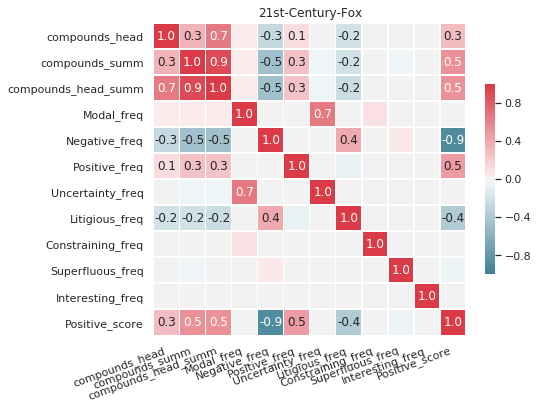

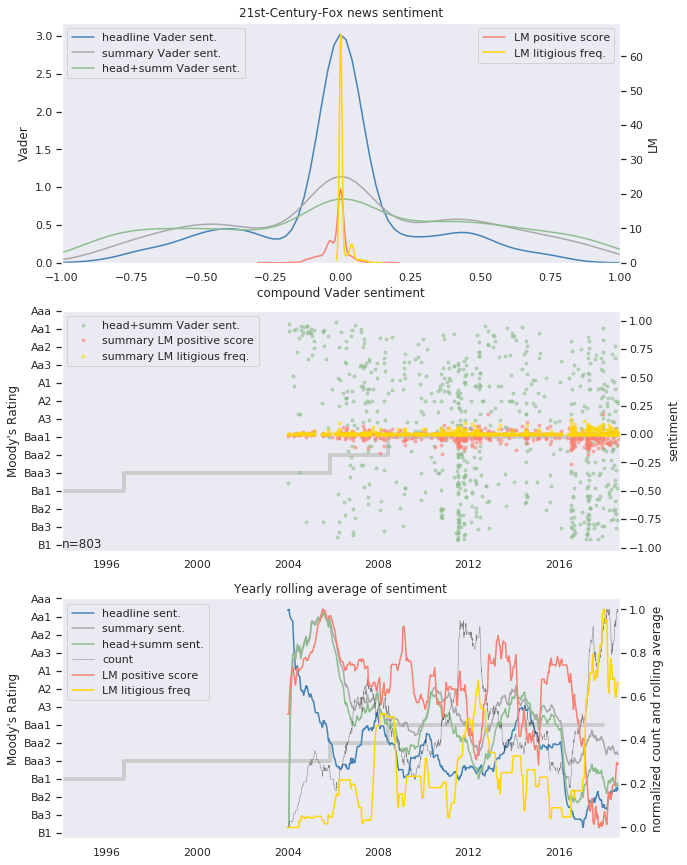

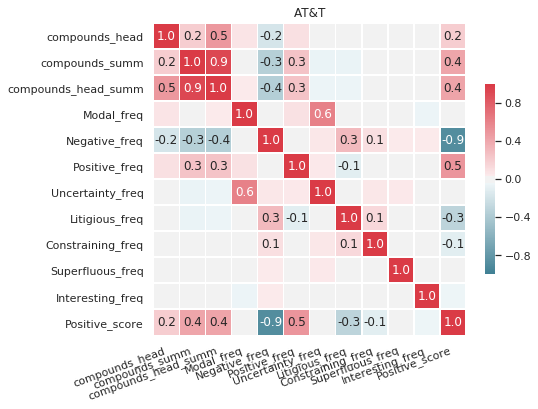

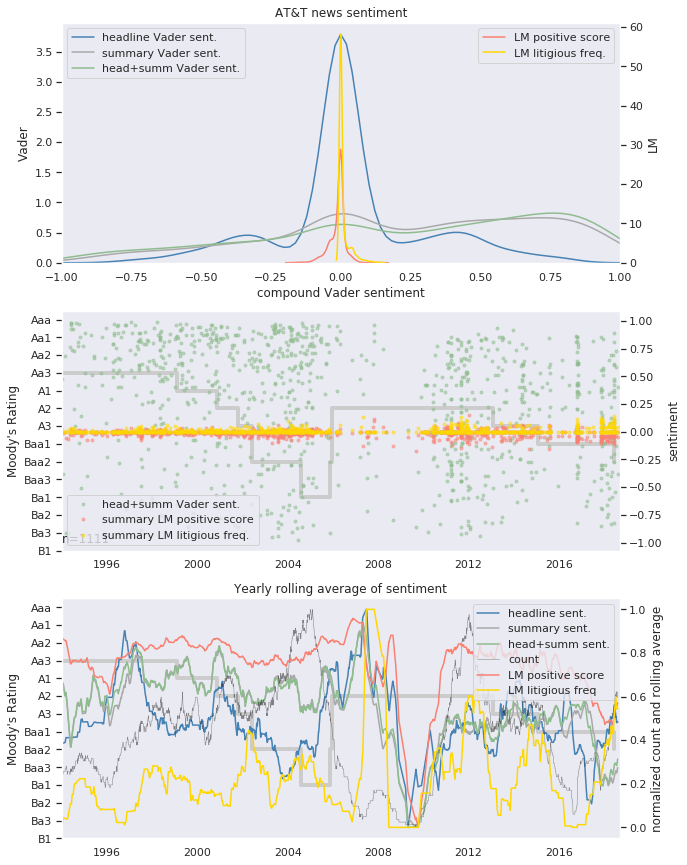

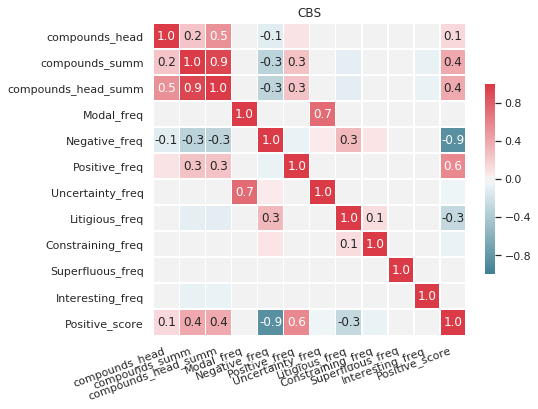

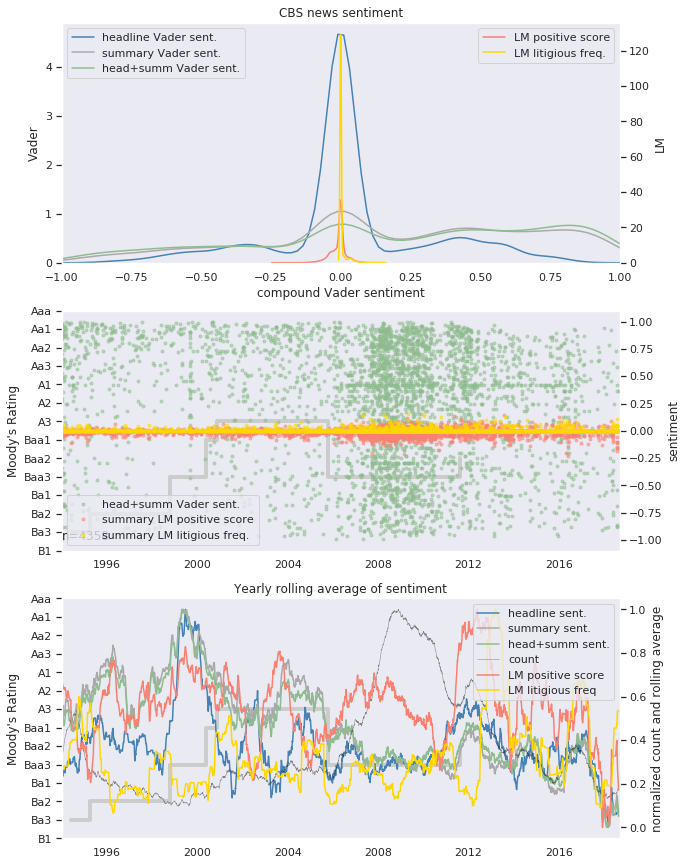

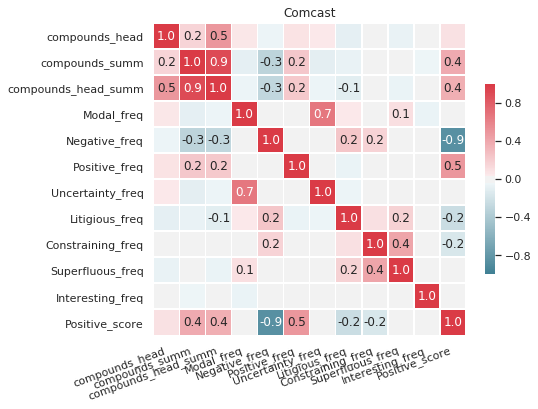

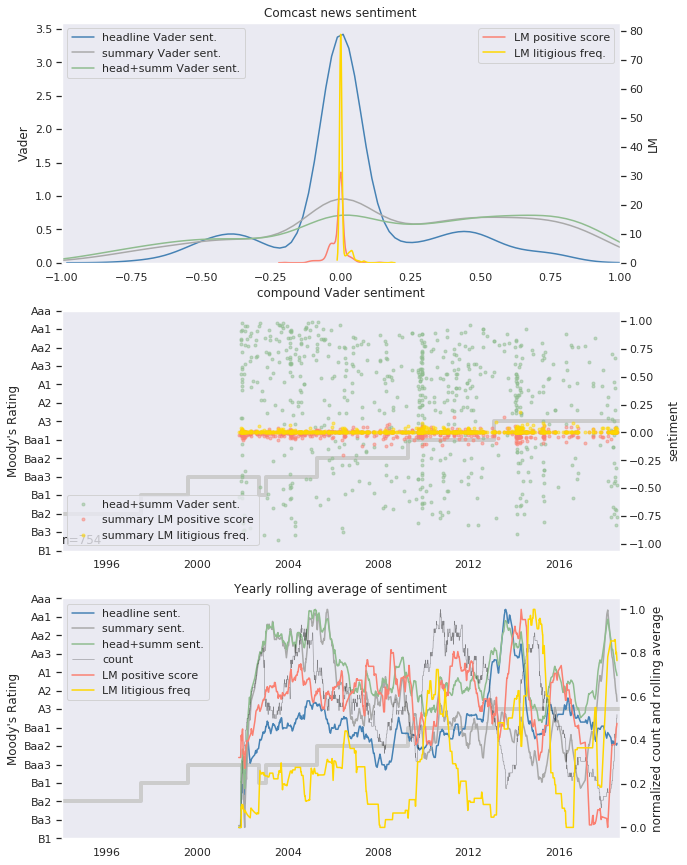

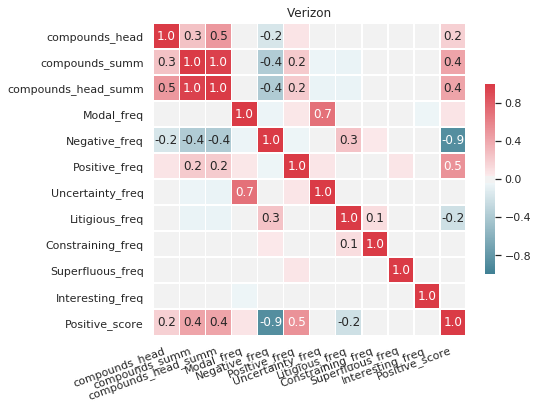

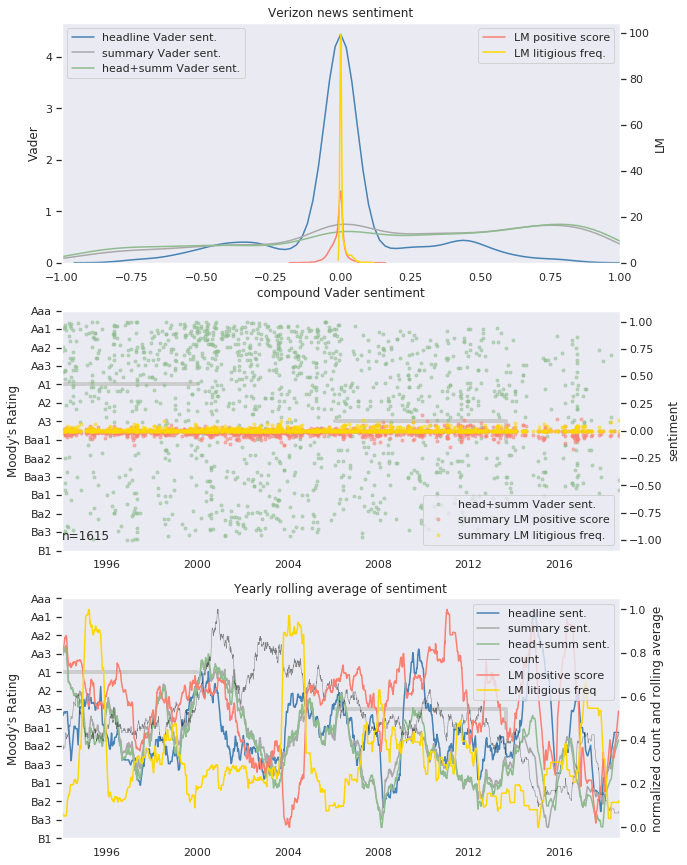

In [18]:
# per-company plots
# - correlation
# - abc company sentiment
# - plotly dots & rolling avg
# also save final df with all sentiments

sns.set(style="dark")

# for comp_name in [comp_names[0]]:
for comp_name in comp_names:
    
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    df = calc_sentiment(df)
    df = map_sentiment_lm(df, 'summary')
    
    # save final df with all sentiments
    df.to_csv(comp_name+'_news_with_sentiment.csv')
    
    df_resample = get_rolling_avg(df, 1)
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca()
    plot_corr(df, comp_name, ax, comp_name)
    fig.savefig('NYT_figs/fig_'+comp_name+'_corr.pdf', bbox_inches='tight')
    
    plot_sentimets(comp_name, df, df_resample)
    
    make_plotly_dots(comp_name, df, plot_offline=True)
    make_plotly_rolling(comp_name, df_resample, plot_offline=True)

#     make_plotly_dots(comp_name, df, plot_offline=False)
#     make_plotly_rolling(comp_name, df_resample, plot_offline=False)


 21st-Century-Fox


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().ffill()




 AT&T

 CBS

 Comcast

 Verizon


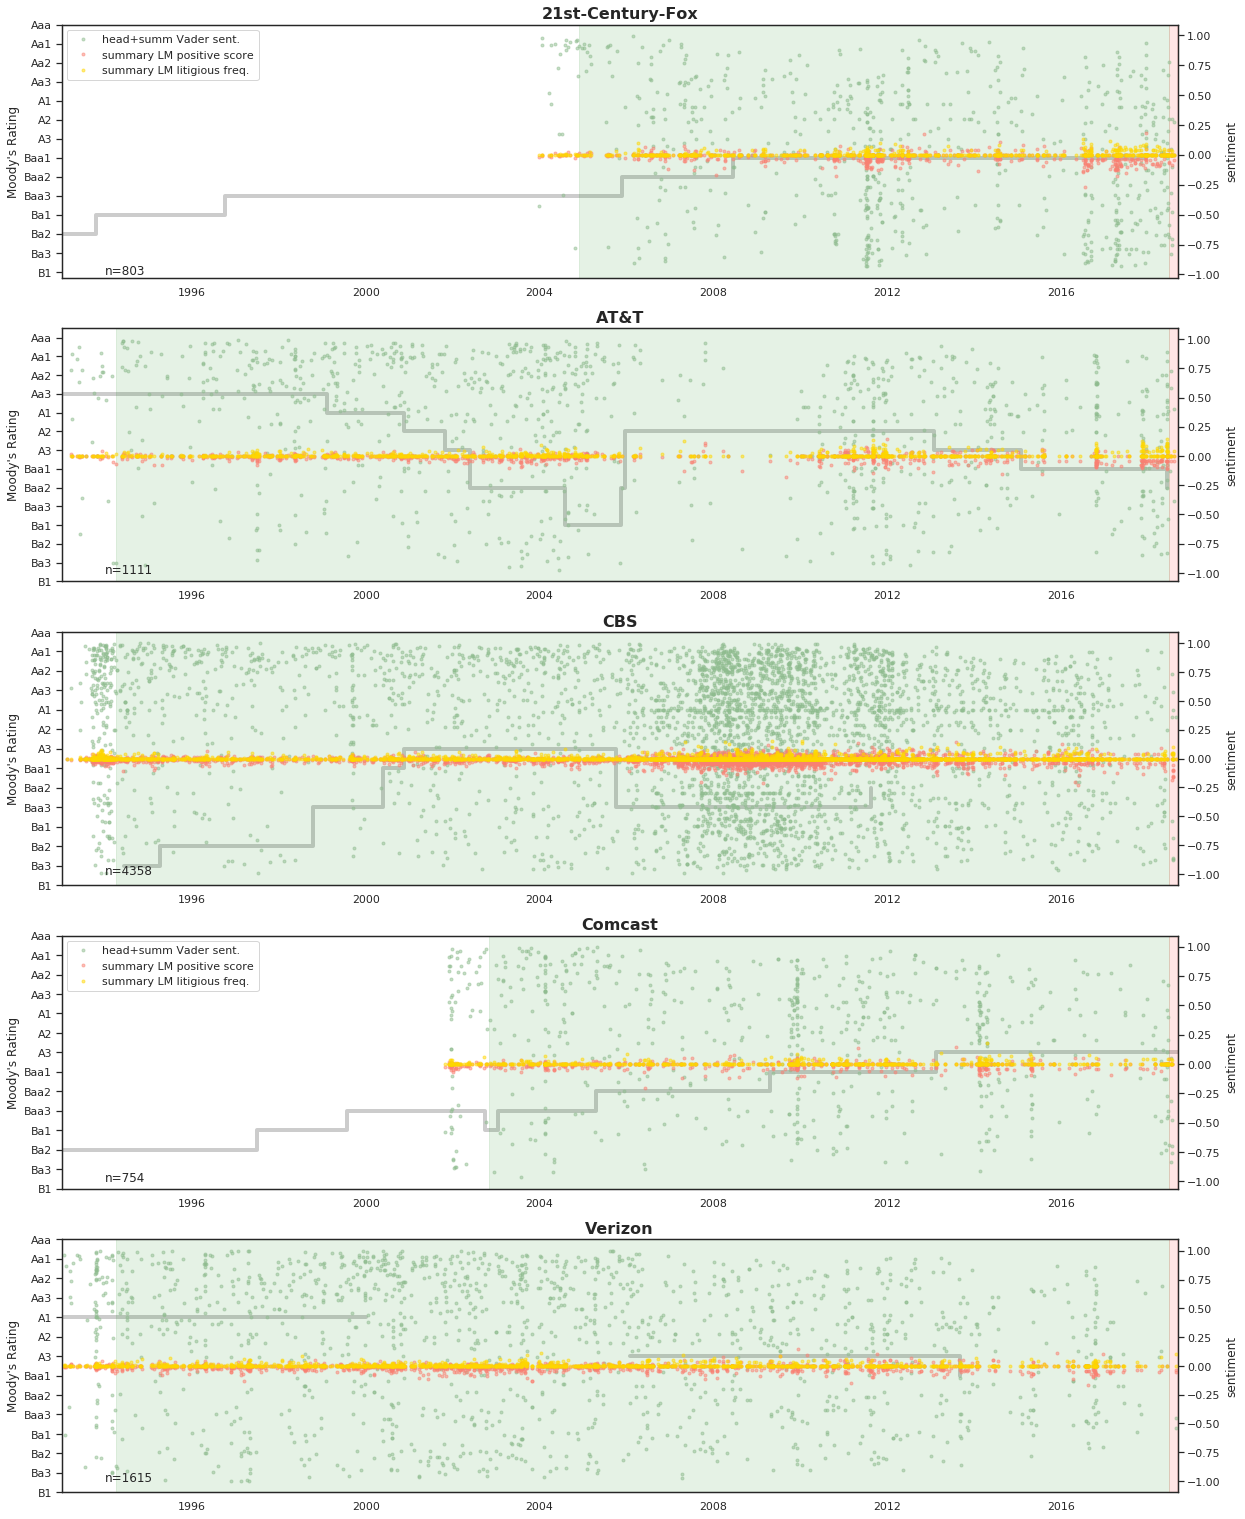

In [19]:
# make combined fig for all 5 companies
# with sentiment on a time axis (dots)

sns.set(style="white")

fig, axes = plt.subplots(5,1, figsize=(20,27))
axes = axes.ravel()

for i, comp_name in enumerate(comp_names):
    
    print('\n', comp_name)
    
    # read and preocess data
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    df = calc_sentiment(df)
    df = map_sentiment_lm(df, 'summary')
    
    df_resample = get_rolling_avg(df, 1)    
        
    # plot
    plot_sentiments_single_dots(comp_name, df, df_resample, axes[i],
                               comp_name, {'size':16, 'weight':'bold'})
    
plt.show()
fig.savefig('NYT_figs/ALL_news_sentiment_single_dots.pdf', bbox_inches='tight')
fig.savefig('NYT_figs/ALL_news_sentiment_single_dots.png', bbox_inches='tight')


 21st-Century-Fox


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().ffill()




 AT&T

 CBS

 Comcast

 Verizon


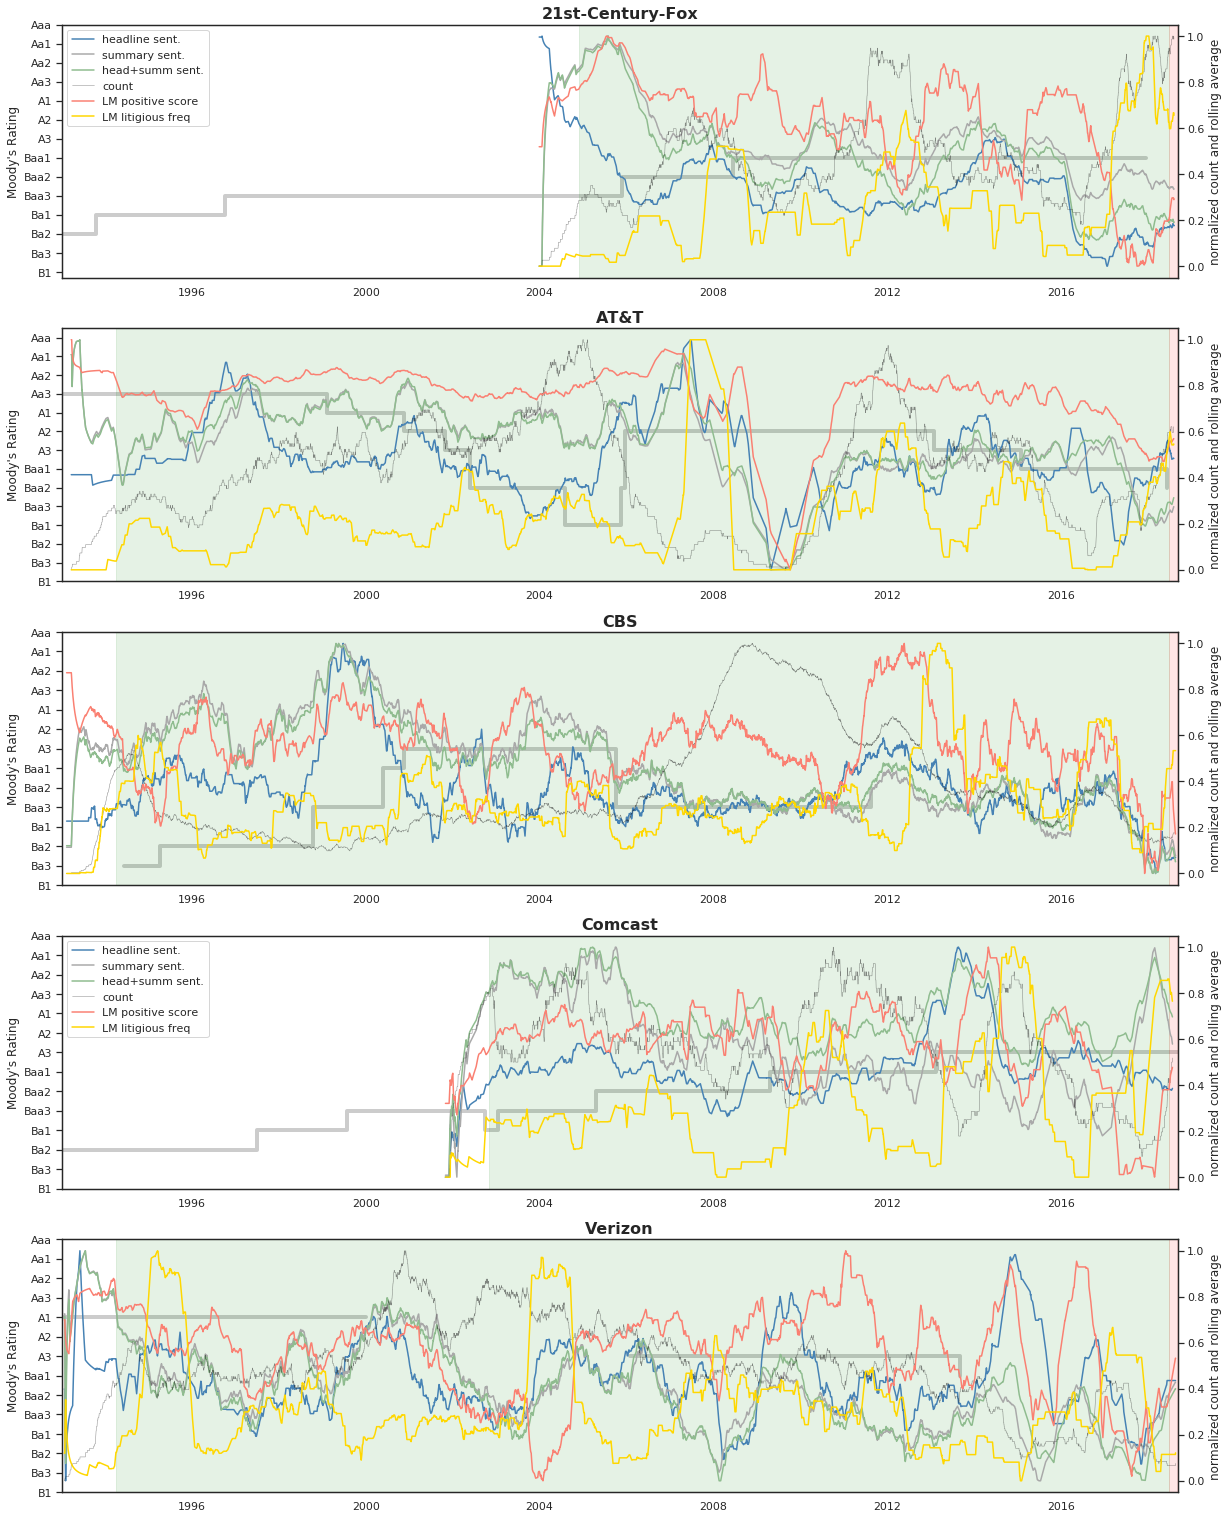

In [20]:
# make combined fig for all 5 companies
# with rolling avg (time series)

sns.set(style="white")

fig, axes = plt.subplots(5,1, figsize=(20,27))
axes = axes.ravel()

for i, comp_name in enumerate(comp_names):
    
    print('\n', comp_name)
    
    # read and process data
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    df = calc_sentiment(df)
    df = map_sentiment_lm(df, 'summary')
    
    df_resample = get_rolling_avg(df, 1)    
        
    # plot
    plot_sentimets_single_rolling(comp_name, df, df_resample, axes[i], 
                                  comp_name, {'size':16, 'weight':'bold'})
    
plt.show()
fig.savefig('NYT_figs/ALL_news_sentiment_single_rolling.pdf', bbox_inches='tight')


 21st-Century-Fox


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().ffill()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



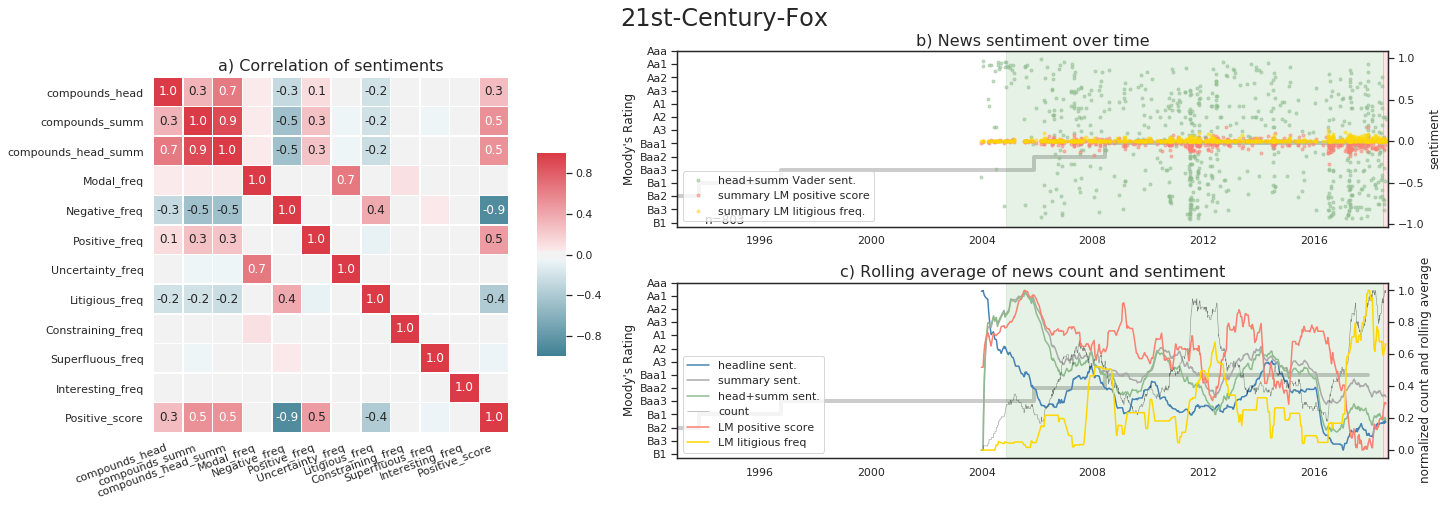


 AT&T


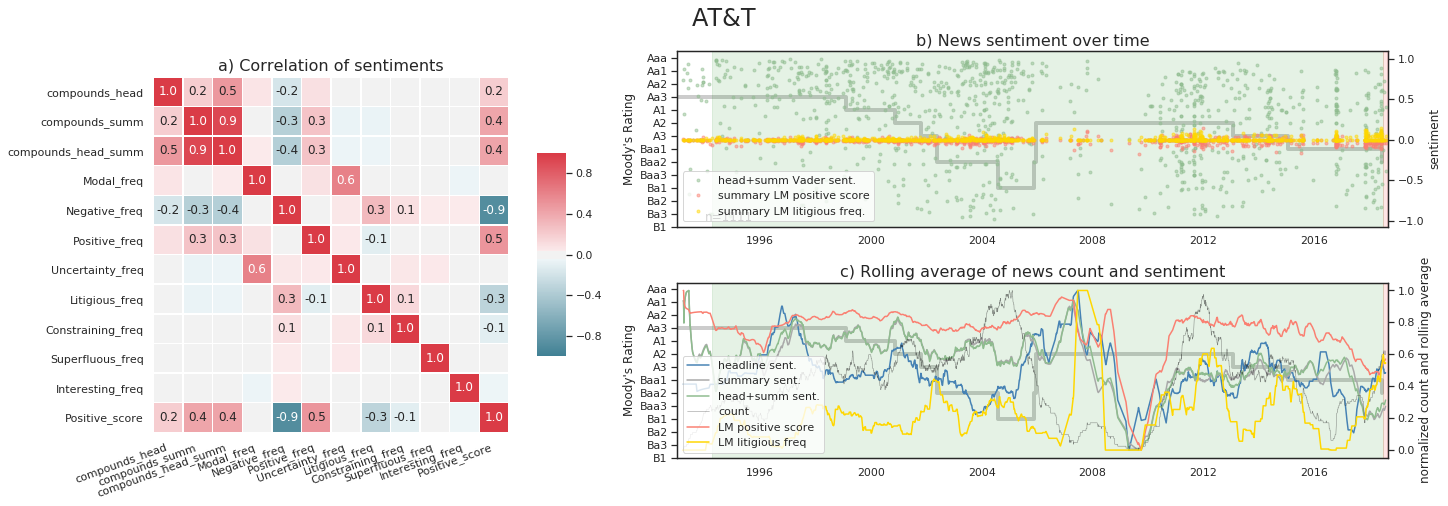


 CBS


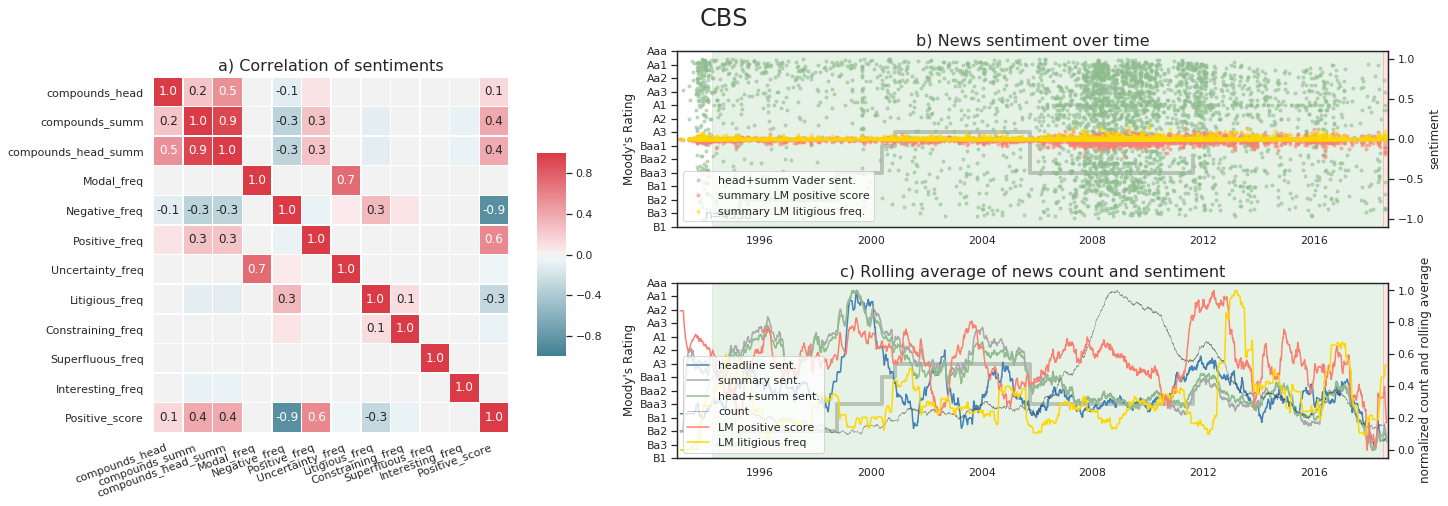


 Comcast


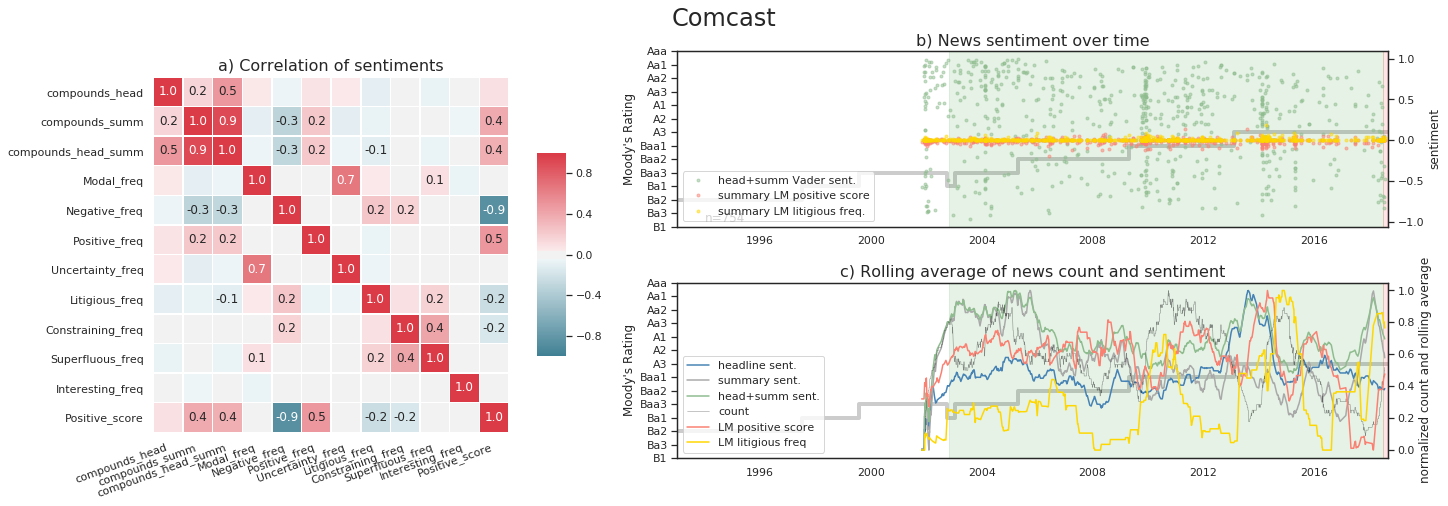


 Verizon


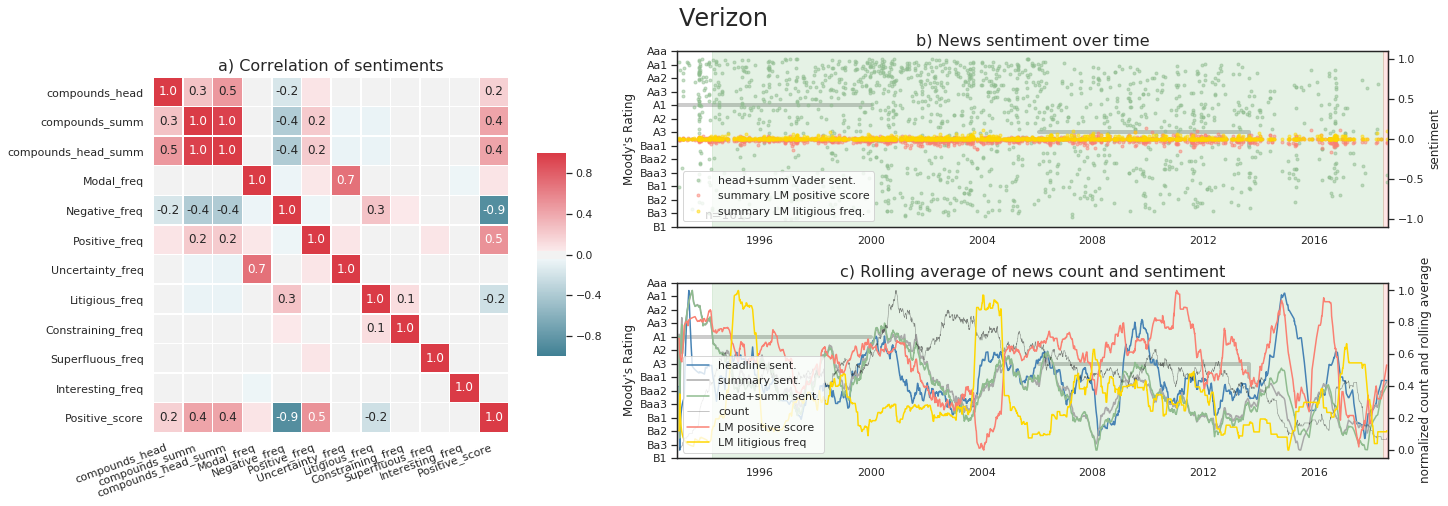

In [21]:
# make corr+dots+rolling plot per company

sns.set(style="white")

for i, comp_name in enumerate(comp_names):
# for i, comp_name in enumerate([comp_names[0]]):
    
    print('\n', comp_name)
    
    # read and process data
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    df = calc_sentiment(df)
    df = map_sentiment_lm(df, 'summary')
    df_resample = get_rolling_avg(df, 1)
    
    # init fig
    fig = plt.figure(constrained_layout=True, figsize=(20,7))
    
    # specify the grid for the uneven subplots
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 2])
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    
    # plot corr
    plot_corr(df, comp_name, ax1, 'a) Correlation of sentiments', fontdict={'size':16})
    
    # plot dots
    plot_sentiments_single_dots(comp_name, df, df_resample, ax2,
                                'b) News sentiment over time',
                                fontdict={'size':16},
                                force_legend=True)
    
    # plot rolling avg
    plot_sentimets_single_rolling(comp_name, df, df_resample, ax3,
                                  'c) Rolling average of news count and sentiment',
                                  fontdict={'size':16},
                                  force_legend=True)
        
    fig.suptitle(comp_name, fontsize=24)

    plt.show()
    fig.savefig('NYT_figs/fig_comb_'+comp_name+'.pdf', bbox_inches='tight')

# Word Cloud

## Weekly count figure

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()



max count: 25
num of peaks: 9 num of merged peaks: 7
max count: 25
num of peaks: 6 num of merged peaks: 5
max count: 29
num of peaks: 120 num of merged peaks: 15
max count: 33
num of peaks: 5 num of merged peaks: 5
max count: 27
num of peaks: 4 num of merged peaks: 4


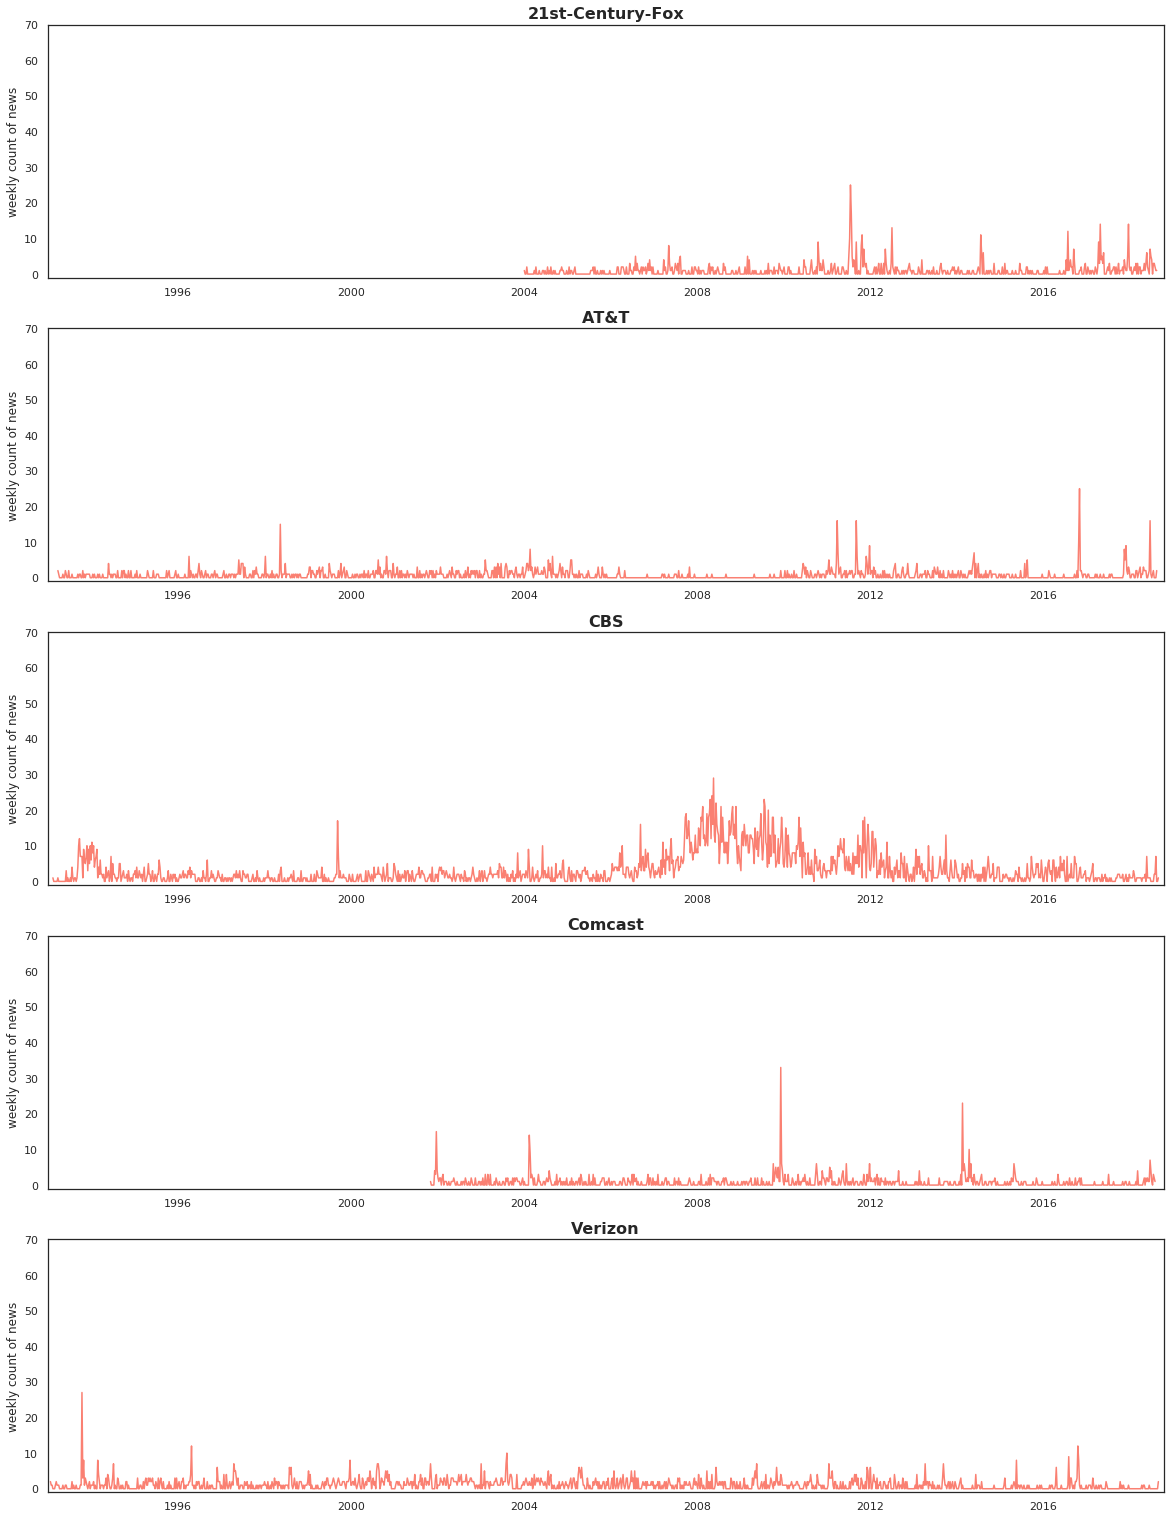

In [22]:
# make fig with weekly count of news

# also get the peaks>=10 weekly counts and +-3 week intervals around them
# also merge the intervals

sns.set(style="white")

fig, axes = plt.subplots(5,1, figsize=(20,27))
axes = axes.ravel()

# init peaks and merged peaks dicts for each company
my_peaks = dict(zip(comp_names, [[],[],[],[],[]]))
my_merged_peaks = dict(zip(comp_names, [[],[],[],[],[]]))

for i, comp_name in enumerate(comp_names):
    
    a = axes[i]
    
    # read and filter the df with news
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)

    # set date as index
    dfx = df
    dfx = dfx.set_index('date')
    
    # resample df - 'W' for weekly
    dfx = dfx.resample('W', how='count')
    
    print('max count:', max(dfx.headline))
    
    
    # recognize a peak with >=10 counts in one week
    # get an interval with +- 3 weeks around that peak
    for ix, count in zip(dfx.index, dfx.headline):
        if count>=10:
            interval_start = ix - dt.timedelta(weeks=3)
            interval_end = ix + dt.timedelta(weeks=3)
            
            my_peaks[comp_name].append([interval_start, interval_end])
            
    
    # merge the peaks if they are overlapping       
    temp_tuple = my_peaks[comp_name]
    merged = [temp_tuple[0]]

    for current in temp_tuple:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
            
    print('num of peaks:', len(temp_tuple), 'num of merged peaks:', len(merged))

    my_merged_peaks[comp_name] = merged
    
    
    # plot
    a.plot(dfx.headline, 'salmon')
    a.set_title(comp_name, fontdict={'size': 16, 'weight':'bold'})
    a.set_ylim([-1,70])
    a.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2018-10-10')])
    a.set_ylabel('weekly count of news')
    
plt.show()
fig.savefig('NYT_figs/ALL_news_count_weekly.pdf', bbox_inches='tight')

## Make word cloud pngs

In [23]:
# save pngs with word clouds for the merged peaks

# from concatenated text remove names of companies
# because they would completely dominate the cloud
# define a dict of key words to remove for each company
keywords_to_remove = dict(zip(comp_names, [[],[],[],[],[]]))
keywords_to_remove['21st-Century-Fox'] = ['News Corporation', 'News Corp ', 'News Corp',
                            '21st Century Fox America Inc ', '21st Century Fox America', '21st Century Fox',
                            'Fox News', 'Fox']
keywords_to_remove['AT&T'] = ['Southwestern Bell Corporation', 'Southwestern Bell Corp ', 'Southwestern Bell',
                            'SBC Communications Corporation', 'SBC Communications Corp', 'SBC Communications', 'SBC',
                            'AT&T Incorporated', 'AT&T Inc ', 'AT&T']
keywords_to_remove['CBS'] = ['Viacom Incorporated', 'Viacom Inc ', 'Viacom',
                            'CBS Corporation', 'CBS Corp ', 'CBS']
keywords_to_remove['Comcast'] = ['AT&T Comcast Corporation', 'AT&T Comcast Corp ', 'AT&T Comcast', 'AT&T',
                            'Comcast Corporation', 'Comcast Corp ', 'Comcast']
keywords_to_remove['Verizon'] = ['Bell Atlantic Corporation', 'Bell Atlantic Corp ', 'Bell Atlantic',
                            'Verizon Communications Inc ', 'Verizon Communications', 'Verizon']

for comp_name in comp_names:
    
    # read the df with news and filter
    dfx = read_df(comp_name)
    dfx = filter_legit_rows(dfx, comp_name)

    # sent date as index
    dfx = dfx.set_index('date')

    # for merged peaks
    for interval in my_merged_peaks[comp_name]:
        
        start_date = str(interval[0])[:10]
        end_date = str(interval[1])[:10]
        
#         print(comp_name, str(start_date))
    
        # get the rows for the peak interval using indexing
        dfx_sub = dfx.loc[start_date:end_date]

        # concatenate headlines and summaries
        h_concat = ''
        s_concat = ''

        for headline, summary in zip(dfx_sub.headline, dfx_sub.summary):
            h_concat += ' ' + str(headline)
            s_concat += ' ' + str(summary)

        text = h_concat.lower()
        # text = s_concat.lower()
        
        # remove key words from the concatenated text (replace with space)
        for key_word in keywords_to_remove[comp_name]:
            text = text.replace(key_word.lower(), ' ')

        # generate a word cloud image
        wordcloud = WordCloud(background_color='white', height=300, width=300, 
                              colormap='winter', ).generate(text)

        # display the generated image        
        image = wordcloud.to_image()
        image.show()
        
        # make white transparent
        img = image.convert("RGBA")
        
        datas = img.getdata()
        
        newData = []
        for item in datas:
            if item[0] == 255 and item[1] == 255 and item[2] == 255:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)

        img.putdata(newData)
        # save PIL image as png file
        img.save('word_clouds/wordcloud_'+comp_name+'_'+start_date+'_'+end_date+'.png', "PNG")

# Count number of search results

Get the number of search results returned by NYT search tool for the search terms and time intervals used for scraping.

In [24]:
# def function to do the check
def get_num_NYT_search(comp_names, all_search_terms, all_search_dates):

    # open a new Firefox browser
    browser = webdriver.Firefox(executable_path='/Users/olahosa/Desktop/CAP/geckodriver')

    # init the df of search results
    df_search_results = pd.DataFrame(index=[item for sublist in all_search_terms for item in sublist],
                                     columns=['comp_name', 'start_date', 'end_date', 'num_search_results'])

    # for each company (and assiciated search terms and search time)
    for comp_name, search_terms, search_dates in zip(comp_names, all_search_terms, all_search_dates):


        for search_term, search_date in zip(search_terms, search_dates):

            start_date = search_date[0]
            end_date = search_date[1]

            # work-around to deal with the fact that search terms for some companies are the same
            if search_term[-2] == '_':
                to_search = search_term[:-2]
            else:
                to_search = search_term

            # construct a query to pass to hte NYT search tool
            query = '%22' + to_search.replace('&', '%26').replace(' ', '%20') + '%22'
            # construct the website that would result from entering that query in NYT search tool
            website = 'https://www.nytimes.com/search?endDate=' + end_date + '&query=' + query + '&sort=best&startDate=' + start_date
            # open that website
            browser.get(website)
            # get the number of results as appear on NYT website after search executed
            # use xpath to access it
            num = browser.find_element_by_xpath('//*[@id="site-content"]/div/div/div[1]/p').text.split()[1]
            # clean the result of the xpath result to be only numerical and cast to int
            num = int(re.sub('[^0-9]','', num))

            # save the all info in the df
            df_search_results['comp_name'][search_term] = comp_name
            df_search_results['start_date'][search_term] = start_date
            df_search_results['end_date'][search_term] = end_date
            df_search_results['num_search_results'][search_term] = num

            print(comp_name, start_date, end_date, to_search, num)
            
    # change dates to datetime type
    df_search_results.start_date = pd.to_datetime(df_search_results.start_date)
    df_search_results.end_date = pd.to_datetime(df_search_results.end_date)
            
    return df_search_results

## Search terms used for scraping

In [25]:
# make a list of comany names and associated lists of:
# - search terms that were used for scraping
# - search intervals for these search terms

comp_names = ['21st-Century-Fox', 'AT&T', 'CBS', 'Comcast', 'Verizon']

all_search_terms = [['News Corp', '21st Century Fox', ], 
                    ['Southwestern Bell', 'SBC', 'AT&T'],
                    ['Viacom', 'CBS'], 
                    ['Comcast_1', 'Comcast_2'], 
                    ['Bell Atlantic', 'Verizon']]

all_search_dates = [[('20031124', '20130705'), ('20130617', '20180831')],
                    [('19930315', '19950509'), ('19941108', '20051121'), ('20051105', '20180831')],
                    [('19930112', '20060109'), ('20060105', '20180831')],
                    [('20011030', '20030110'), ('20021030', '20180831')],
                    [('19930121', '20001114'), ('20000908', '20180831')]]

# get num of search results
df_search_results = get_num_NYT_search(comp_names, all_search_terms, all_search_dates)
df_search_results

21st-Century-Fox 20031124 20130705 News Corp 1104
21st-Century-Fox 20130617 20180831 21st Century Fox 867
AT&T 19930315 19950509 Southwestern Bell 166
AT&T 19941108 20051121 SBC 1576
AT&T 20051105 20180831 AT&T 671546
CBS 19930112 20060109 Viacom 3148
CBS 20060105 20180831 CBS 25320
Comcast 20011030 20030110 Comcast 186
Comcast 20021030 20180831 Comcast 4309
Verizon 19930121 20001114 Bell Atlantic 1852
Verizon 20000908 20180831 Verizon 7564


comp_name start_date   end_date num_search_results
News Corp          21st-Century-Fox 2003-11-24 2013-07-05               1104
21st Century Fox   21st-Century-Fox 2013-06-17 2018-08-31                867
Southwestern Bell              AT&T 1993-03-15 1995-05-09                166
SBC                            AT&T 1994-11-08 2005-11-21               1576
AT&T                           AT&T 2005-11-05 2018-08-31             671546
Viacom                          CBS 1993-01-12 2006-01-09               3148
CBS                             CBS 2006-01-05 2018-08-31              25320
Comcast_1                   Comcast 2001-10-30 2003-01-10                186
Comcast_2                   Comcast 2002-10-30 2018-08-31               4309
Bell Atlantic               Verizon 1993-01-21 2000-11-14               1852
Verizon                     Verizon 2000-09-08 2018-08-31               7564

In [26]:
# modify the df with search count to be output as latex to put in the report

# group by company and sum up the numbers
df_counts = df_search_results.groupby(by='comp_name', axis=0).sum().join(df_counts, how='inner')

# manually check num search results for at&t inc as shows up automatically in NYT 
# search with the time-span of interest
df_counts['num_search_results']['AT&T'] = 33345

# fill in 'search terms' column
df_counts.insert(loc=0, column='search_terms', value=np.nan)
df_counts['search_terms']['21st-Century-Fox'] = '"News Corp", "21st Century Fox"'
df_counts['search_terms']['AT&T'] = '"Southwestern Bell", "SBC", at&t inc'
df_counts['search_terms']['CBS'] = '"Viacom", "CBS"'
df_counts['search_terms']['Comcast'] = '"Comcast"'
df_counts['search_terms']['Verizon'] = '"Bell Atlantic", "Verizon"'

# add 'filtered' column
for comp_name in comp_names:    
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    df_counts['filtered'][comp_name] = df.shape[0]

# output as latex
print(df_counts.to_latex())

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFram

\begin{tabular}{llrlll}
\toprule
{} &                          search\_terms &  num\_search\_results & concat & deduped & filtered \\
comp\_name        &                                       &                     &        &         &          \\
\midrule
21st-Century-Fox &       "News Corp", "21st Century Fox" &                1971 &   1970 &    1970 &      803 \\
AT\&T             &  "Southwestern Bell", "SBC", at\&t inc &               33345 &  32930 &   30899 &     1111 \\
CBS              &                       "Viacom", "CBS" &               28468 &  24950 &   23730 &     4358 \\
Comcast          &                             "Comcast" &                4495 &   4107 &    4026 &      754 \\
Verizon          &            "Bell Atlantic", "Verizon" &                9416 &   7108 &    7096 &     1615 \\
\bottomrule
\end{tabular}



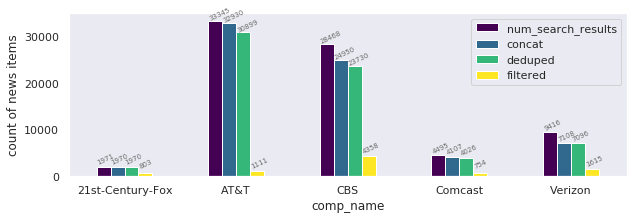

In [56]:
# fig with counts from the final search count df 

sns.set(style="dark")

fig, ax = plt.subplots(1,1, figsize=(10,3))

df_counts.plot(kind='bar', ax=ax, rot=0, colormap='viridis')
ax.set_ylabel('count of news items')

# set individual bar lables
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+2000, \
            str(i.get_height()), fontsize=7, color='dimgrey',
                rotation=25)

plt.show()
fig.savefig('NYT_figs/news_counts.pdf', bbox_inches='tight')
fig.savefig('NYT_figs/news_counts.png', bbox_inches='tight')

## Search terms for context

For context, get number of NYT search results for other possible search terms.

In [28]:
comp_names = ['21st-Century-Fox', 'AT&T', 'CBS', 'Comcast', 'Verizon']

all_search_terms = [['News Corporation', 'News Corp',
                     '21st Century Fox America Inc', '21st Century Fox America', '21st Century Fox'],
                    
                    ['Southwestern Bell Corp', 'Southwestern Bell',
                     'SBC Communications Corp', 'SBC Communications', 'SBC',
                     'AT&T Inc', 'AT&T_1'],
                    
                    ['Viacom Inc', 'Viacom',
                     'CBS Corp', 'CBS'], 
                    
                    ['AT&T Comcast Corp', 'AT&T Comcast', 'AT&T_2', 'Comcast_1',
                     'Comcast Corp', 'Comcast_2'], 
                    
                    ['Bell Atlantic Corp', 'Bell Atlantic',
                     'Verizon Communications Inc', 'Verizon Communications', 'Verizon']]

all_search_dates = [[('20031124', '20130705'), ('20031124', '20130705'),
                     ('20130617', '20180831'), ('20130617', '20180831'), ('20130617', '20180831')],
                    
                    [('19930315', '19950509'), ('19930315', '19950509'),
                     ('19941108', '20051121'), ('19941108', '20051121'), ('19941108', '20051121'),
                     ('20051105', '20180831'), ('20051105', '20180831')],
                    
                    [('19930112', '20060109'), ('19930112', '20060109'),
                     ('20060105', '20180831'), ('20060105', '20180831')],
                    
                    [('20011030', '20030110'), ('20011030', '20030110'), ('20011030', '20030110'), ('20011030', '20030110'),
                     ('20021030', '20180831'), ('20021030', '20180831')],
                    
                    [('19930121', '20001114'), ('19930121', '20001114'), 
                     ('20000908', '20180831'), ('20000908', '20180831'), ('20000908', '20180831')]
]

In [29]:
# get num of search results
df_search_results = get_num_NYT_search(comp_names, all_search_terms, all_search_dates)
df_search_results

21st-Century-Fox 20031124 20130705 News Corporation 4523
21st-Century-Fox 20031124 20130705 News Corp 1104
21st-Century-Fox 20130617 20180831 21st Century Fox America Inc 0
21st-Century-Fox 20130617 20180831 21st Century Fox America 0
21st-Century-Fox 20130617 20180831 21st Century Fox 867
AT&T 19930315 19950509 Southwestern Bell Corp 29
AT&T 19930315 19950509 Southwestern Bell 166
AT&T 19941108 20051121 SBC Communications Corp 0
AT&T 19941108 20051121 SBC Communications 1157
AT&T 19941108 20051121 SBC 1576
AT&T 20051105 20180831 AT&T Inc 654
AT&T 20051105 20180831 AT&T 671546
CBS 19930112 20060109 Viacom Inc 1157
CBS 19930112 20060109 Viacom 3148
CBS 20060105 20180831 CBS Corp 854
CBS 20060105 20180831 CBS 25320
Comcast 20011030 20030110 AT&T Comcast Corp 0
Comcast 20011030 20030110 AT&T Comcast 45
Comcast 20011030 20030110 AT&T 46146
Comcast 20011030 20030110 Comcast 186
Comcast 20021030 20180831 Comcast Corp 388
Comcast 20021030 20180831 Comcast 4309
Verizon 19930121 20001114 Bell A

comp_name start_date   end_date  \
News Corporation              21st-Century-Fox 2003-11-24 2013-07-05   
News Corp                     21st-Century-Fox 2003-11-24 2013-07-05   
21st Century Fox America Inc  21st-Century-Fox 2013-06-17 2018-08-31   
21st Century Fox America      21st-Century-Fox 2013-06-17 2018-08-31   
21st Century Fox              21st-Century-Fox 2013-06-17 2018-08-31   
Southwestern Bell Corp                    AT&T 1993-03-15 1995-05-09   
Southwestern Bell                         AT&T 1993-03-15 1995-05-09   
SBC Communications Corp                   AT&T 1994-11-08 2005-11-21   
SBC Communications                        AT&T 1994-11-08 2005-11-21   
SBC                                       AT&T 1994-11-08 2005-11-21   
AT&T Inc                                  AT&T 2005-11-05 2018-08-31   
AT&T_1                                    AT&T 2005-11-05 2018-08-31   
Viacom Inc                                 CBS 1993-01-12 2006-01-09   
Viacom                                     CBS 1993-01-12 2006-01-09   
CBS Corp                                   CBS 2006-01-05 2018-08-31   
CBS                                        CBS 2006-01-05 2018-08-31   
AT&T Comcast Corp                      Comcast 2001-10-30 2003-01-10   
AT&T Comcast                           Comcast 2001-10-30 2003-01-10   
AT&T_2                                 Comcast 2001-10-30 2003-01-10   
Comcast_1                              Comcast 2001-10-30 2003-01-10   
Comcast Corp                           Comcast 2002-10-30 2018-08-31   
Comcast_2                              Comcast 2002-10-30 2018-08-31   
Bell Atlantic Corp                     Verizon 1993-01-21 2000-11-14   
Bell Atlantic                          Verizon 1993-01-21 2000-11-14   
Verizon Communications Inc             Verizon 2000-09-08 2018-08-31   
Verizon Communications                 Verizon 2000-09-08 2018-08-31   
Verizon                                Verizon 2000-09-08 2018-08-31   

                             num_search_results  
News Corporation                           4523  
News Corp                                  1104  
21st Century Fox America Inc                  0  
21st Century Fox America                      0  
21st Century Fox                            867  
Southwestern Bell Corp                       29  
Southwestern Bell                           166  
SBC Communications Corp                       0  
SBC Communications                         1157  
SBC                                        1576  
AT&T Inc                                    654  
AT&T_1                                   671546  
Viacom Inc                                 1157  
Viacom                                     3148  
CBS Corp                                    854  
CBS                                       25320  
AT&T Comcast Corp                             0  
AT&T Comcast                                 45  
AT&T_2                                    46146  
Comcast_1                                   186  
Comcast Corp                                388  
Comcast_2                                  4309  
Bell Atlantic Corp                          447  
Bell Atlantic                              1852  
Verizon Communications Inc                  695  
Verizon Communications                     1711  
Verizon                                    7564

In [30]:
# output as latex to put in the report
print(df_search_results.to_latex())

\begin{tabular}{lllll}
\toprule
{} &         comp\_name & start\_date &   end\_date & num\_search\_results \\
\midrule
News Corporation             &  21st-Century-Fox & 2003-11-24 & 2013-07-05 &               4523 \\
News Corp                    &  21st-Century-Fox & 2003-11-24 & 2013-07-05 &               1104 \\
21st Century Fox America Inc &  21st-Century-Fox & 2013-06-17 & 2018-08-31 &                  0 \\
21st Century Fox America     &  21st-Century-Fox & 2013-06-17 & 2018-08-31 &                  0 \\
21st Century Fox             &  21st-Century-Fox & 2013-06-17 & 2018-08-31 &                867 \\
Southwestern Bell Corp       &              AT\&T & 1993-03-15 & 1995-05-09 &                 29 \\
Southwestern Bell            &              AT\&T & 1993-03-15 & 1995-05-09 &                166 \\
SBC Communications Corp      &              AT\&T & 1994-11-08 & 2005-11-21 &                  0 \\
SBC Communications           &              AT\&T & 1994-11-08 & 2005-11-21 &         

# Other tasks

## Basic df checks

In [31]:
# do some basic checks on the news df

for comp_name in comp_names:
    
    print()
    print(comp_name)
    
    df = read_df(comp_name)
    df = filter_legit_rows(df, comp_name)
    
    print(' summaries with length<10 ch:', sum(df.summary.str.len()<10), 
          '\n headline with length<2 ch:', sum(df.headline.str.len()<2), 
          '\n link with length<2 ch:', sum(df.link.str.len()<10),
          '\n videos:', sum(df.link.str.contains("video")),
          '\n dates with length<5 ch:', sum(df.date.map(str).str.len()<5),
          '\n is num dates==19 equal to total records:', sum(df.date.map(str).str.len()==19)==df.shape[0])


21st-Century-Fox
 summaries with length<10 ch: 0 
 headline with length<2 ch: 0 
 link with length<2 ch: 0 
 videos: 5 
 dates with length<5 ch: 0 
 is num dates==19 equal to total records: True

AT&T
 summaries with length<10 ch: 0 
 headline with length<2 ch: 0 
 link with length<2 ch: 0 
 videos: 5 
 dates with length<5 ch: 0 
 is num dates==19 equal to total records: True

CBS
 summaries with length<10 ch: 0 
 headline with length<2 ch: 0 
 link with length<2 ch: 0 
 videos: 24 
 dates with length<5 ch: 0 
 is num dates==19 equal to total records: True

Comcast
 summaries with length<10 ch: 0 
 headline with length<2 ch: 0 
 link with length<2 ch: 0 
 videos: 6 
 dates with length<5 ch: 0 
 is num dates==19 equal to total records: True

Verizon
 summaries with length<10 ch: 0 
 headline with length<2 ch: 0 
 link with length<2 ch: 0 
 videos: 11 
 dates with length<5 ch: 0 
 is num dates==19 equal to total records: True


## Get rows with no date

In [32]:
# save a new df with only missing dates to do full scrape on them

# for comp_name in comp_names:

#     dfx = pd.read_csv('NYT_url-head-sum/'+comp_name+'_ALL_filtered.csv')

#     # for i in range(dfx.shape[0]):
#     #     if pd.isnull(dfx.date.iloc[i]):
#     #         print(dfx.link.iloc[i], dfx.headline.iloc[i])

#     # get only missing dates
#     df_new = dfx[pd.isnull(dfx.date)]
#     # skip videos
#     df_new = df_new[~df_new.link.str.contains("video")]

#     print(df_new.shape[0], dfx.shape[0], comp_name)

#     df_new.to_csv('NYT_url-head-sum/'+comp_name+'_nodate.csv')